In [1]:
import datetime
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import random
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

seed = 42


In [2]:
followers_archive = pd.read_hdf('dog_rates_follower_count.h5')

thandle = followers_archive.archive_url[0][followers_archive.archive_url[0].rindex('/')+1:]
print('Twitter handle:', '@{}'.format(thandle))


Twitter handle: @dog_rates


In [3]:
tweets = pd.read_hdf('dog_rates_tweets_archive.h5').reset_index()


In [4]:
tweets_followers_archive = pd.DataFrame()

# specific to scraped datasets, matching time of Tweet to current follower count
for i,tweet in tweets.iterrows():
    idx = np.argmin(np.abs(followers_archive.archive_created_at - tweet['created_at']))
    dat = followers_archive.loc[[idx]]
    tweets_followers_archive = tweets_followers_archive.append(dat, ignore_index=True)


In [5]:
tweets_concat = pd.concat([tweets, tweets_followers_archive], axis=1)
tweets_concat['favorite_count_log'] = np.log10(tweets_concat['favorite_count'].mask(tweets_concat['favorite_count'] == 0)).fillna(1)
tweets_concat['favorite_count_per_follower'] = tweets_concat['favorite_count']/tweets_concat['follower_count']
tweets_concat['retweet_count_per_follower'] = tweets_concat['retweet_count']/tweets_concat['follower_count']
tweets_concat = tweets_concat.sort_values(by='created_at', ignore_index=True)                                               


In [6]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val < 0:
        sign = '-'
    else:
        sign = ''
    
    if np.abs(tick_val) >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{0}{1:}B'.format(sign,val)
    elif np.abs(tick_val) >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{0}{1:}M'.format(sign, val)
    elif np.abs(tick_val) >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{0}{1:}K'.format(sign, val)
    elif np.abs(tick_val) < 1000:
        val = round(tick_val, 1)
        new_tick_format = '{0}{1:}'.format(sign, val)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]

    return new_tick_format

In [7]:
# interested in time period following intial growth
# specific to WeRateDogs dataset, need to implement way to remove period of initial growth
tweets_clip = tweets_concat[tweets_concat['created_at'] > datetime.datetime(2018,9,5)]


In [8]:
# prepare data for clustering algorithm
tweets_clustering = tweets_clip.drop(['index','id','created_at','in_reply_to_status_id',
                                        'in_reply_to_user_id','in_reply_to_screen_name','full_text',
                                        'hashtags_bool','user_mentions','urls_bool','media_url','media_type',
                                        'archive_created_at','archive_url','follower_count','delta_follower',
                                        'delta_follower_pct','per_time','delta_follower_per_time',
                                        'retweet_count_per_follower'], axis=1)

# formatting categorical data
tweets_clustering = tweets_clustering.where(pd.notnull(tweets_clustering), 'FALSE')

mask = tweets_clustering.applymap(type) != bool
d = {True: 'TRUE', False: 'FALSE'}

tweets_clustering = tweets_clustering.where(mask, tweets_clustering.replace(d))


In [9]:
# identify continuous (i.e., numerical) and categorical data
num_feats = ['retweet_count', 'favorite_count', 'favorite_count_log', 'favorite_count_per_follower']
cat_feats = ['is_quote_status', 'hashtags', 'user_mentions_bool', 'urls', 'media_bool', 'in_reply_bool']
# scale continuous data
scale = StandardScaler()
tweets_clustering[num_feats] = scale.fit_transform(tweets_clustering[num_feats])


In [10]:
# One hot encoding/dummy variable encoding of categorical data

inertia = []

n_clusters = 30

for k in range(1,n_clusters+1):
    #TODO: scale data after OHE
    model = KMeans(n_clusters=k, random_state=seed).fit(pd.get_dummies(tweets_clustering))
    inertia.append(model.inertia_)
    
kn = KneeLocator(range(1,n_clusters+1), inertia, curve='convex', direction='decreasing')
K = kn.knee
print('Optimal number of clusters:', K)

plt.plot(range(1,n_clusters+1), inertia, c='dodgerblue')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.axvline(K, c='k', ls='--')

plt.tight_layout()

plt.savefig(thandle + '_inertia_n_clusters.png', dpi=300)

plt.close()


Optimal number of clusters: 6


In [11]:
#TODO: scale data after OHE
model = KMeans(n_clusters=K, random_state=seed).fit(pd.get_dummies(tweets_clustering))
pred = model.labels_


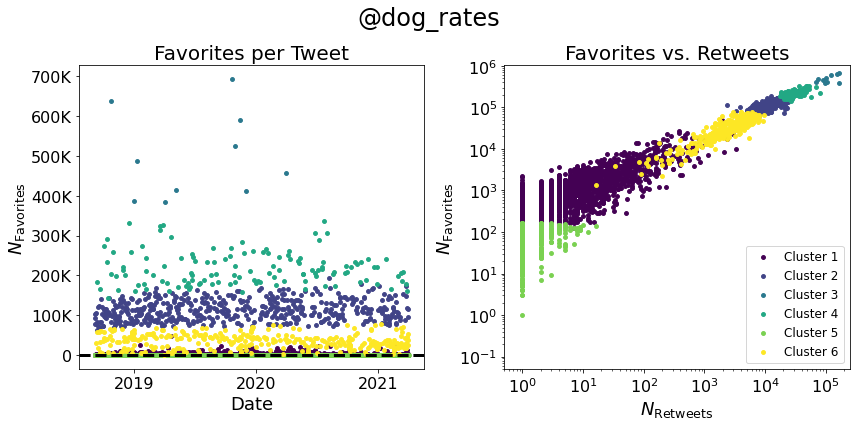

In [12]:
# plot the clusters
fig, ax = plt.subplots(1,2, figsize=(12,6))

grouped_clusters = tweets_clip.groupby(pred)

cgen = mpl.cm.viridis([c/(K-1) for c in range(K)])

for c,df in grouped_clusters:
    ax[0].scatter(df.created_at, df.favorite_count, color=cgen[c], s=15, label='Cluster {}'.format(c+1))

ax[0].set_xlabel('Date')
ax[0].set_ylabel('$N_\mathrm{Favorites}$')
ax[0].set_title('Favorites per Tweet')
ax[0].axhline(0.0, c='k', ls='--')
xticks = [datetime.datetime.strptime('{}-01-01'.format(y), '%Y-%m-%d') for y in range(df.created_at.min().year, df.created_at.max().year + 1)]
xtick_labels = [x.year for x in xticks]
if xticks[0] + datetime.timedelta(days=90) < df.created_at.min():
    xticks = xticks[1:]
    xtick_labels = xtick_labels[1:]
if xticks[-1] - datetime.timedelta(days=90) > df.created_at.max():
    xticks.append(xticks[-1]+datetime.timedelta(days=365))
    xtick_labels.append(xtick_labels[-1]+1)
    
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xtick_labels)

ax[0].yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

for c,df in grouped_clusters:
    ax[1].scatter(df.retweet_count, df.favorite_count, color=cgen[c], s=15, label='Cluster {}'.format(c+1))

ax[1].set_xlabel('$N_\mathrm{Retweets}$')
ax[1].set_ylabel('$N_\mathrm{Favorites}$')
ax[1].set_title('Favorites vs. Retweets')
ax[1].set_xscale('log')
ax[1].set_xlim(0.5, max(tweets_clip.retweet_count)*1.5)
ax[1].set_yscale('log')
ax[1].set_ylim(0.05, max(tweets_clip.favorite_count)*1.5)

ax[1].legend(loc=4, fontsize=12)

fig.suptitle('@{}'.format(thandle), fontsize=24)
    
plt.tight_layout()
    
plt.savefig(thandle + '_clusters.png', dpi=300)


In [13]:
# info about the clusters
for c, df in grouped_clusters:
    print('Cluster', c+1, '(Number of Tweets: {})'.format(len(df)))
    print('Most tweets are replies?', df['in_reply_bool'].mode().tolist()[0])
    print('Most tweets include media?', df['media_bool'].mode().tolist()[0])
    print('Hashtags:')
    for i, count in enumerate(df['hashtags'].value_counts()[:4]):
        if count/len(df) > 0.015:
            print('    ', df['hashtags'].value_counts()[:4].index.tolist()[i])
    print('URLS:')
    for i, count in enumerate(df['urls'].value_counts()[:3]):
        if count/len(df) > 0.005:
            print('    ', df['urls'].value_counts()[:3].index.tolist()[i])
    print('N_Favorites', int(df['favorite_count'].median()))
    print('N_Retweets', int(df['retweet_count'].median()))
    print('\n')


Cluster 1 (Number of Tweets: 2167)
Most tweets are replies? True
Most tweets include media? False
Hashtags:
URLS:
     twitter
N_Favorites 808
N_Retweets 5


Cluster 2 (Number of Tweets: 484)
Most tweets are replies? False
Most tweets include media? True
Hashtags:
     SeniorPupSaturday
URLS:
     twitter
N_Favorites 111535
N_Retweets 10883


Cluster 3 (Number of Tweets: 10)
Most tweets are replies? False
Most tweets include media? True
Hashtags:
URLS:
N_Favorites 471400
N_Retweets 103015


Cluster 4 (Number of Tweets: 127)
Most tweets are replies? False
Most tweets include media? True
Hashtags:
     PrideMonthPuppo
     SeniorPupSaturday
URLS:
     twitter
N_Favorites 208278
N_Retweets 27239


Cluster 5 (Number of Tweets: 1525)
Most tweets are replies? True
Most tweets include media? False
Hashtags:
URLS:
     weratedogs
     publishing.andrewsmcmeel
N_Favorites 33
N_Retweets 0


Cluster 6 (Number of Tweets: 331)
Most tweets are replies? False
Most tweets include media? True
Hashtags:

In [14]:
ad_cluster = int(input('Which cluster looks like it is mostly made up of ad Tweets?  Cluster '))

Which cluster looks like it is mostly made up of ad Tweets?  Cluster 6


In [15]:
ads = grouped_clusters.get_group(ad_cluster-1)


In [16]:
# calculate median change in followers over the next 7 days
ad_follower_change = []
for i,ad in enumerate(ads['created_at']):
    time_delta = ad + datetime.timedelta(days=7)

    loid = tweets_concat.index[tweets_concat['created_at'] == ad].to_list()[0]
    hiid = tweets_concat['created_at'].loc[(tweets_concat['created_at'] > ad) & ((tweets_concat['created_at'] <= time_delta))]
    hiid = hiid.iloc[[-1]].index.to_list()[0]
    
    ad_follower_change.append(tweets_concat['delta_follower_per_time'].iloc[loid:hiid].median())
    
ads.loc[:, 'ad_follower_change'] = ad_follower_change


In [17]:
ols = LinearRegression() # create LinearRegression object
x_fit = np.asarray(pd.to_datetime(ads.created_at).astype(int).astype(float)).reshape(-1, 1) # use created_at as feature
y_fit = np.asarray(ads.ad_follower_change) # use median change in followers as target
ols.fit(x_fit, y_fit) # fit the OLS model
slope_ols = ols.coef_[0]
intercept_ols = ols.intercept_

y_pred = intercept_ols + x_fit*slope_ols

lossy_tweets = []
gainy_tweets = []
for i,ad in enumerate(ads['ad_follower_change']):
    #TODO: check tweets over the last day that might also have cause significant changes
    if (ad - y_pred[i])[0] > 2.5*np.std(y_fit):
        gainy_tweets.extend(ads['full_text'].iloc[i-2:i].to_list())
    if (ad - y_pred[i])[0] <= -1.0*np.std(y_fit):
        lossy_tweets.extend(ads['full_text'].iloc[i-2:i].to_list())
                        

In [18]:
from fpdf import FPDF
import textwrap

pdf = FPDF()

dupes_loss = set([x for n, x in enumerate(lossy_tweets) if x in lossy_tweets[:n]])


# Add a page
pdf.add_page()
  
# set style and size of font 
# that you want in the pdf
pdf.set_font("Arial", size = 16)
  
# create a cell
pdf.cell(200, 10, txt = 'Tweets that potentially caused some loss of Followers:\n\n', 
         ln = 1, align = 'L')
pdf.cell(200, 10, txt = '', 
         ln = 2, align = 'L')

# add another cell
pdf.set_font("Arial", size = 14)
tweet_string = ''
fact = 3
random.seed(seed)
rand_idx = random.sample(range(0, len(dupes_loss)), 3)
for i,d in enumerate(dupes_loss):
    if i in rand_idx:
        string_encode = d.encode('ascii', 'ignore')
        string_decode = string_encode.decode()
        d = textwrap.wrap(string_decode, width=80)

        for j in d:
            pdf.cell(200, 10, txt=j, ln = fact, align = 'L')
            fact += 0.5
        pdf.cell(200, 10, txt='', ln = fact, align = 'L')
        fact += 1
        

pdf.output(thandle + '_lossy_tweets.pdf')  
pdf.close()


In [19]:
pdf = FPDF()

dupes_gain = set([x for n, x in enumerate(gainy_tweets) if x in gainy_tweets[:n]])


# Add a page
pdf.add_page()
  
# set style and size of font 
# that you want in the pdf
pdf.set_font("Arial", size = 16)
  
# create a cell
pdf.cell(200, 10, txt = 'Tweets that potentially caused some gain in Followers:\n\n', 
         ln = 1, align = 'L')
pdf.cell(200, 10, txt = '', 
         ln = 2, align = 'L')
  
# add another cell
pdf.set_font("Arial", size = 14)
tweet_string = ''
fact = 3
random.seed(seed)
rand_idx = random.sample(range(0, len(dupes_gain)), 3)
for i,d in enumerate(dupes_gain):
    if i in rand_idx:
        string_encode = d.encode('ascii', 'ignore')
        string_decode = string_encode.decode()
        d = textwrap.wrap(string_decode, width=80)

        for j in d:
            pdf.cell(200, 10, txt=j, ln = fact, align = 'L')
            fact += 0.5
        pdf.cell(200, 10, txt='', ln = fact, align = 'L')
        fact += 1
        

pdf.output(thandle + '_gainy_tweets.pdf')  
pdf.close()
